# 중요: README

본 코드는 LSTM 모델을 training 하는 코드이다.

# 전처리 Scheme
이 ipynb파일을 바탕으로 딥러닝 모델을 만들면 된다.

만약 처음부터 끝까지 정보가 필요하다면 원본 코드를 참조하면 된다.

https://colab.research.google.com/drive/1_89gAFgKXN3J1FzdLcUExPpK2eli3mY7?authuser=1#scrollTo=Eh_LVBG7crR9


전처리 scheme은 다음과 같다.
- X-CA, Y-CA, Z-CA는 모두 정규화
- structure_detail의 경우 각 열마다 의미가 있기 때문에 one-hot encoding을 중심으로 진행. 우선 structure_detail에 등장하는 고유 문자의 종류는 (https://www.mankier.com/1/mkdssp#Synopsis 참고; 공백은 전부 해당 없다는 뜻):
  - `{' ', '<', '>', 'P'}`: **`structure_detail1`**-> helix 종류
  - `{' ', '3', 'X', '<', '>'}`: **`structure_detail2`** -> helix 종류
  - `{' ', '4', 'X', '<', '>'}`: **`structure_detail3`** -> helix 종류
  - `{' ', 'X', '<', '>', '5'}`: **`structure_detail4`** -> helix 종류
  - `{' ', 'S'}`: **`structure_detail5`** -> Bend 위치
  - `{' ', '-', '+'}`: **`structure_detail6`** -> chirality
  - `{'U', 's', 'Q', 'O', 'e', 'g', 'R', 'd', 'D', 'Z', 'H', 'w', 'v', 'V', 'G', 'a', 'p', 'W', 'l', 'M', 'C', 'o', 'S', 'j', 'F', 'i', 'u', 'L', 'K', 'q', 'N', 'm', 'k', 'X', 'z', 'c', 'A', 'Y', 'y', 'b', 't', 'P', ' ', 'f', 'I', 'h', 'n', 'r', 'J', 'E', 'B', 'x', 'T'}`: : **`structure_detail7`** -> beta-bridge label
  - `{'U', 's', 'e', 'O', 'Q', 'g', 'R', 'd', 'D', 'Z', 'H', 'w', 'v', 'V', 'G', 'p', 'a', 'W', 'l', 'M', 'C', 'o', 'S', 'j', 'F', 'i', 'u', 'L', 'K', 'q', 'm', 'N', 'k', 'X', 'z', 'c', 'Y', 'A', 'y', 'b', 't', 'P', ' ', 'f', 'I', 'h', 'n', 'r', 'J', 'E', 'B', 'x', 'T'}` **`structure_detail8`**-> beta bridge label

여기서 helix이 종류는 P, 3, 4, 5이고, `>`는 시작점, `>`는 끝점이라는 뜻이다. beta-bridge label은 같은 알파벳끼리 bridge를 형성한다는 뜻이다. 예를 들어 `structure_detail7`에서 1-5 redsidue에 A, 60-75 residue에 A가 온다면 이 위치에 bridge가 온다는 뜻이다. 즉 알파벳은 일종의 cluster라고 볼 수 있고, 등장한 순서대로 A-Z가 붙는다. 소문자의 경우 parallel이 다른 경우. 그러나 bridge가 26개가 넘어가는 경우 어떤 일이 일어나는지는 데이터상 알 수 없었다.

- structure_detail1-6 one hot encoding (범주형 변수), structure_detail7-8 제거 (cluster를 반영하는 방법을 모르겠음)
- ACC열 제거: 인접한 물 분자의 수. 단백질 구조와 관련이 없기 때문에 제거



# 라이브러리 불러오기

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 파일 경로 설정하기

In [ ]:
# 작업 폴더를 해당 경로로 수정
%cd /content/drive/MyDrive/Datasets/PDB Raw

/content/drive/MyDrive/Datasets/PDB Raw


# 쿼리 종류 불러오기

In [ ]:
# legacy 데이터베이스에 있는 4글자 코드를 모두 리스트에 저장
four_letter_code_legacy = [] # 4글자 코드 리스트

filename = 'pdb_four_letter_legacy.txt'
f = open(filename, 'r')
lines = f.readlines()

for line in lines:
    four_letter_code_legacy.append(line[-10:-6])

print(four_letter_code_legacy)

['8dmx', '1dma', '4dmw', '3dmw', '8dmu', '5dmx', '4dm5', '3dmy', '7dmb', '1dmr', '8dm1', '4dmg', '1dmt', '5dm0', '8dmt', '3dmt', '4dm7', '3dmk', '2dmg', '2dmq', '3dmr', '7dma', '5dmj', '3dmc', '1dmg', '5dmq', '8dmg', '1dmb', '5dml', '7dm1', '7dm2', '3dmz', '2dms', '4dmv', '1dm0', '8dme', '7dmq', '8dmp', '1dmm', '8dmk', '6dmp', '6dmf', '7dmf', '6dmh', '8dmi', '2dmh', '4dmb', '6dm9', '5dm3', '5dm2', '7dm6', '6dmz', '4dm1', '6dm0', '8dmr', '1dmy', '8dmh', '2dmi', '1dmc', '2dmt', '5dm5', '6dmo', '7dmn', '6dm3', '6dmv', '8dmb', '6dmb', '2dmp', '3dmv', '7dmx', '7dmm', '6dmn', '7dme', '3dm2', '6dmy', '3dmi', '8dml', '2dm3', '7dmc', '7dmk', '1dm3', '4dmn', '3dmm', '1dmx', '3dmh', '5dmi', '7dmg', '1dml', '5dmf', '3dme', '1dm5', '1dmk', '1dmw', '8dm9', '4dmo', '2dm4', '5dm4', '1dm9', '2dmk', '2dmv', '8dm2', '4dme', '6dm4', '2dmx', '3dml', '4dmu', '1dme', '4dm8', '6dmj', '6dmg', '6dmd', '2dmj', '7dm9', '6dmu', '3dmx', '7dmy', '2dmd', '1dmo', '2dm5', '2dmw', '7dm4', '3dm5', '4dmf', '5dmg', '1dmh',

In [ ]:
# cif 데이터베이서에 있는 4글자 코드를 모두 리스트에 저장
# 워낙 양이 많기 때문에 10개만 print (전부 print 하려면 오류남)
four_letter_code_cif = []

filename = 'pdb_four_letter_cif.txt'
f = open(filename, 'r')
lines = f.readlines()

for line in lines:
    four_letter_code_cif.append(line[-12:-8])

print(four_letter_code_cif[0:10])

['7dmf', '2dm9', '2dmt', '7dmg', '8dmm', '6dmz', '4dm2', '1dme', '3dm3', '4dmh']


In [ ]:
# 몇개의 query가 있는가? legacy
len(four_letter_code_legacy)

216606

In [ ]:
# 몇개의 query가 있는가? cif - 확실히 최근 데이터라 이게 더 많다
len(four_letter_code_cif)

439188

# 데이터 다운로드 함수

In [ ]:
import subprocess
import os

# 데이터 다운로드 받는 함수
# https://www.scrapingbee.com/blog/python-wget/
def runcmd(cmd, verbose = False, *args, **kwargs):

    process = subprocess.Popen(
        cmd,
        stdout = subprocess.PIPE,
        stderr = subprocess.PIPE,
        text = True,
        shell = True
    )
    std_out, std_err = process.communicate()
    if verbose:
        print(std_out.strip(), std_err)
    pass

# Header, Data 분리 함수

In [ ]:
# DSSP 파일은 처음에 데이터 설명 및 Flag가 많기 때문에, 이것을 제외하고 Tidy dataframe 만 추출
def read_useful_data(file_path):
    obsolete_data = []
    header = []
    useful_data = []
    output_data = []
    with open(file_path, 'r') as f:
        # Skip lines until you find the line starting with '#'
        for line in f:
          if '#  RESIDUE' in line: # description에 '#'이 있는 경우가 있어서 RESIDUE 까지 붙여줌
            header = line.strip().split()
          elif '!' in line: # ! is missing residue
            pass
          elif not header:
            obsolete_data.append(line.strip())
          else:
            useful_data.append(line)


    return header, useful_data

# 전체 전처리 함수

In [ ]:
def preprocess_dssp(data):
  # 각 line을 인덱싱하여 리스트로 저장
  residue_num=[]
  AA=[]
  structure_x=[]
  structure_detail=[]
  BP1=[]
  BP2=[]
  ACC=[]
  N_H__O_11=[]
  N_H__O_12=[]
  O__H_N_11=[]
  O__H_N_12=[]
  N_H__O_21=[]
  N_H__O_22=[]
  O__H_N_21=[]
  O__H_N_22=[]
  TCO=[]
  KAPPA=[]
  ALPHA=[]
  PHI=[]
  PSI=[]
  X_CA=[]
  Y_CA=[]
  Z_CA=[]

  variables_name=['residue_num', 'AA', 'structure_x', 'structure_detail', 'BP1', 'BP2', 'ACC',
           'N_H__O_11', 'N_H__O_12', 'O__H_N_11','O__H_N_12', 'N_H__O_21', 'N_H__O_22', 'O__H_N_21', 'O__H_N_22',
           'TCO', 'KAPPA', 'ALPHA', 'PHI', 'PSI', 'X_CA', 'Y_CA', 'Z_CA']
  variables_value=[residue_num, AA, structure_x, structure_detail, BP1, BP2, ACC,
           N_H__O_11, N_H__O_12, O__H_N_11,O__H_N_12, N_H__O_21, N_H__O_22, O__H_N_21, O__H_N_22,
           TCO, KAPPA, ALPHA, PHI, PSI, X_CA, Y_CA, Z_CA]

  for i in data:
    line=i.split()
    residue_num.append(i[6:10]) # line[1]->i[6:10] 변경
    AA.append(i[13]) # line[3] -> i[13] 변경
    X_CA.append(line[-3])
    Y_CA.append(line[-2])
    Z_CA.append(line[-1])

    structure_x.append(i[16])
    structure_detail.append(i[17:25])
    BP1.append(i[25:29]) # 30->29 변경
    BP2.append(i[29:34]) # 31->29 , 35->34 변경
    ACC.append(i[35:38]) # 35->34, 39->38 변경
    N_H__O_11.append(i[40:45])
    N_H__O_12.append(i[46:50]) # 52->50 변경
    O__H_N_11.append(i[53:56])
    O__H_N_12.append(i[57:61]) # 63->61 변경
    N_H__O_21.append(i[62:67]) # 63->62 변경
    N_H__O_22.append(i[68:72]) # 74->72 변경
    O__H_N_21.append(i[73:78]) # 75-_73 변경
    O__H_N_22.append(i[79:83]) # 85->83 변경
    TCO.append(i[85:91])
    KAPPA.append(i[91:97])
    ALPHA.append(i[97:103])
    PHI.append(i[103:109])
    PSI.append(i[109:116])

  # 모든 리스트를 데이터프레임에 저장
  cleaned_data=pd.DataFrame()

  for i in range(len(variables_name)):
    df=pd.DataFrame({variables_name[i]: variables_value[i]})
    cleaned_data=pd.concat([cleaned_data, df], axis=1)

  # structure label이 결측일 경우 'O' 로 대체
  cleaned_data['structure_x_1']=cleaned_data['structure_x'].replace(' ', 'O')
  cleaned_data['structure_x']=cleaned_data['structure_x'].replace(' ', 'O')
  cleaned_data = cleaned_data.drop(columns=['structure_x_1'])

  ## Structure Detail 전처리
  # 새로운 열 만들기
  for i in range(8):
    cleaned_data[f'structure_detail{i+1}'] = cleaned_data['structure_detail'].str[i]

  # structure_detail7, structure_detail8 제거
  cleaned_data = cleaned_data.drop(columns=['structure_detail7', 'structure_detail8'])

  # change datatype for each column
  cleaned_data['residue_num'] = cleaned_data['residue_num'].astype(float).astype('int32')
  cleaned_data['ACC'] = cleaned_data['ACC'].astype(float)
  cleaned_data['N_H__O_11'] = cleaned_data['N_H__O_11'].astype(float)
  cleaned_data['N_H__O_12'] = cleaned_data['N_H__O_12'].astype(float)
  cleaned_data['O__H_N_11'] = cleaned_data['O__H_N_11'].astype(float)
  cleaned_data['O__H_N_12'] = cleaned_data['O__H_N_12'].astype(float)
  cleaned_data['N_H__O_21'] = cleaned_data['N_H__O_21'].astype(float)
  cleaned_data['N_H__O_22'] = cleaned_data['N_H__O_22'].astype(float)
  cleaned_data['O__H_N_21'] = cleaned_data['O__H_N_21'].astype(float)
  cleaned_data['O__H_N_22'] = cleaned_data['O__H_N_22'].astype(float)
  cleaned_data['TCO'] = cleaned_data['TCO'].astype(float)
  cleaned_data['KAPPA'] = cleaned_data['KAPPA'].astype(float)
  cleaned_data['ALPHA'] = cleaned_data['ALPHA'].astype(float)
  cleaned_data['PHI'] = cleaned_data['PHI'].astype(float)
  cleaned_data['PSI'] = cleaned_data['PSI'].astype(float)
  cleaned_data['X_CA'] = cleaned_data['X_CA'].astype(float)
  cleaned_data['Y_CA'] = cleaned_data['Y_CA'].astype(float)
  cleaned_data['Z_CA'] = cleaned_data['Z_CA'].astype(float)

  # 불필요한 열 제거: ACC, BP1, BP2, residue_num, structure_detail, AA
  cleaned_data = cleaned_data.drop(columns=['ACC', 'BP1', 'BP2', 'residue_num', 'structure_detail'])

  # X-CA, Y-CA, Z-CA 정규화
  coordinate_col = ['X_CA', 'Y_CA', 'Z_CA']


  # Initialize the StandardScaler
  scaler = StandardScaler()

  # Normalize the numerical columns
  cleaned_data[coordinate_col] = scaler.fit_transform(cleaned_data[coordinate_col])

  return cleaned_data

# 아미노산 one-hot encoding 함수

총 20개 열

In [ ]:
amino_acids = list('ACDEFGHIKLMNPQRSTVWY')  # 20 standard amino acids

def one_hot_encode(df, column, amino_acids):
    one_hot_df = pd.DataFrame(0, index=df.index, columns=amino_acids)
    for aa in amino_acids:
        one_hot_df[aa] = (df[column] == aa).astype(int)
    return pd.concat([df, one_hot_df], axis=1).drop(columns=['AA']) # 원래 'AA' 열 드랍

# `structure_x` one-hot encoding 함수

- H = α-helix
- B = residue in isolated β-bridge
- E = extended strand, participates in β ladder
- G = 3-helix (310 helix)
- I = 5 helix (π-helix)
- T = hydrogen bonded turn
- S = bend

여기에 우리가 그외를 O로 만들었었다.

총 8개 열

In [ ]:
structures = list('HBEGITSO')

def one_hot_encode_structure(df, column, structures):
  one_hot_df = pd.DataFrame(0, index = df.index, columns = structures)
  for st in structures:
    one_hot_df[st] = (df[column] == st).astype(int) # True = 1, False = 0

  one_hot_df.columns = ['ss_'+i for i in structures]

  return pd.concat([df, one_hot_df], axis=1).drop(columns=['structure_x']) # 원래 'structure_x' 열 드랍

In [ ]:
structures

['H', 'B', 'E', 'G', 'I', 'T', 'S', 'O']

In [ ]:
['ss_'+i for i in structures]

['ss_H', 'ss_B', 'ss_E', 'ss_G', 'ss_I', 'ss_T', 'ss_S', 'ss_O']

# `structure_detail` one-hot encoding 함수

각 단백질마다 structure_detail에 있는 정보가 다르기 때문에 이것도 one-hot encoding 통일해줘야 함.

- `{' ', '<', '>', 'P'}`: structure_detail1-> helix 종류
- `{' ', '3', 'X', '<', '>'}`: structure_detail2 -> helix 종류
- `{' ', '4', 'X', '<', '>'}`: structure_detail3 -> helix 종류
- `{' ', 'X', '<', '>', '5'}`: structure_detail4 -> helix 종류
- `{' ', 'S'}`: structure_detail5 -> Bend 위치
- `{' ', '-', '+'}`: structure_detail6 -> chirality

총 24개 열

In [ ]:
def encode_structure_details(df):
    # Define mapping for each structure detail column
    mapping = {
        'structure_detail1': {' ': 'b', '<': '<', '>': '>', 'P': 'P'},
        'structure_detail2': {' ': 'b', '3': '3', 'X': 'X', '<': '<', '>': '>'},
        'structure_detail3': {' ': 'b', '4': '4', 'X': 'X', '<': '<', '>': '>'},
        'structure_detail4': {' ': 'b', 'X': 'X', '<': '<', '>': '>', '5': '5'},
        'structure_detail5': {' ': 'b', 'S': 'S'},
        'structure_detail6': {' ': 'b', '-': '-', '+': '+'}
    }

    # Iterate over each structure detail column and encode values
    for col, mapping_dict in mapping.items():
        # Create new columns for each category in the mapping
        for category, code in mapping_dict.items():
            new_col = col + '_' + code
            df[new_col] = (df[col] == category).astype(int)

    # Drop the original structure detail columns
    df.drop(columns=['structure_detail1', 'structure_detail2',
                     'structure_detail3', 'structure_detail4',
                     'structure_detail5', 'structure_detail6'], inplace=True)

    return df

# Example usage
# Assuming df is your dataframe containing structure details columns
# encoded_df = encode_structure_details(df)

# 예시

In [ ]:
# 예시 쿼리
query = '7dmg'

runcmd(f"wget https://pdb-redo.eu/dssp/db/{query}/legacy", verbose = True)
os.rename('legacy', f"{query}.dssp")

 --2024-06-30 04:49:27--  https://pdb-redo.eu/dssp/db/7dmg/legacy
Resolving pdb-redo.eu (pdb-redo.eu)... 192.87.97.253
Connecting to pdb-redo.eu (pdb-redo.eu)|192.87.97.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘legacy’

     0K .......... .......... .......... .......... ..........  119K
    50K .......... .......... .......                          31.2M=0.4s

2024-06-30 04:49:28 (185 KB/s) - ‘legacy’ saved [79655]




In [ ]:
header, data = read_useful_data(f"{query}.dssp")

In [ ]:
dssp_7dmg = preprocess_dssp(data=data)
dssp_7dmg

,AA,structure_x,N_H__O_11,N_H__O_12,O__H_N_11,O__H_N_12,N_H__O_21,N_H__O_22,O__H_N_21,O__H_N_22,...,PSI,X_CA,Y_CA,Z_CA,structure_detail1,structure_detail2,structure_detail3,structure_detail4,structure_detail5,structure_detail6
0,S,O,0.0,0.0,3.0,-1.6,0.0,0.0,2.0,-0.1,...,-0.2,2.719048,0.055497,-0.882980,,>,,,,
1,M,T,1.0,-0.3,3.0,-0.1,3.0,-0.0,0.0,0.0,...,133.9,2.897903,-0.127658,-0.780102,,3,,,,+
2,G,T,1.0,-0.2,2.0,-0.4,-2.0,-0.1,-1.0,-0.3,...,6.6,2.843469,-0.161575,-0.487295,,3,,,S,+
3,E,O,-3.0,-1.6,2.0,-0.7,11.0,-0.0,-1.0,-0.2,...,129.3,2.563523,-0.080173,-0.503122,,<,,,,-
4,I,O,11.0,-0.4,11.0,-2.3,-2.0,-0.4,2.0,-0.4,...,115.3,2.314682,-0.215843,-0.550604,,,,,,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,G,T,-287.0,-0.3,3.0,-2.5,-289.0,-0.3,-1.0,-0.3,...,6.9,0.899400,-0.107307,-0.503122,,>,,,S,+
548,Y,T,-3.0,-1.9,-2.0,-0.1,1.0,-0.3,-287.0,-0.1,...,-35.2,1.000491,-0.344730,-0.550604,,<,,,,+
549,T,T,1.0,-0.2,-1.0,-0.3,-97.0,-0.1,-288.0,-0.1,...,-3.9,0.751650,-0.426132,-0.700965,,3,,,S,+
550,C,O,-3.0,-2.5,-1.0,-0.2,-354.0,-0.1,-2.0,-0.2,...,-46.8,0.782755,-0.229410,-0.906721,,<,,,,


In [ ]:
dssp_7dmg = encode_structure_details(dssp_7dmg)
dssp_7dmg

,AA,structure_x,N_H__O_11,N_H__O_12,O__H_N_11,O__H_N_12,N_H__O_21,N_H__O_22,O__H_N_21,O__H_N_22,...,structure_detail4_b,structure_detail4_X,structure_detail4_<,structure_detail4_>,structure_detail4_5,structure_detail5_b,structure_detail5_S,structure_detail6_b,structure_detail6_-,structure_detail6_+
0,S,O,0.0,0.0,3.0,-1.6,0.0,0.0,2.0,-0.1,...,1,0,0,0,0,1,0,1,0,0
1,M,T,1.0,-0.3,3.0,-0.1,3.0,-0.0,0.0,0.0,...,1,0,0,0,0,1,0,0,0,1
2,G,T,1.0,-0.2,2.0,-0.4,-2.0,-0.1,-1.0,-0.3,...,1,0,0,0,0,0,1,0,0,1
3,E,O,-3.0,-1.6,2.0,-0.7,11.0,-0.0,-1.0,-0.2,...,1,0,0,0,0,1,0,0,1,0
4,I,O,11.0,-0.4,11.0,-2.3,-2.0,-0.4,2.0,-0.4,...,1,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,G,T,-287.0,-0.3,3.0,-2.5,-289.0,-0.3,-1.0,-0.3,...,1,0,0,0,0,0,1,0,0,1
548,Y,T,-3.0,-1.9,-2.0,-0.1,1.0,-0.3,-287.0,-0.1,...,1,0,0,0,0,1,0,0,0,1
549,T,T,1.0,-0.2,-1.0,-0.3,-97.0,-0.1,-288.0,-0.1,...,1,0,0,0,0,0,1,0,0,1
550,C,O,-3.0,-2.5,-1.0,-0.2,-354.0,-0.1,-2.0,-0.2,...,1,0,0,0,0,1,0,1,0,0


In [ ]:
dssp_7dmg = one_hot_encode(dssp_7dmg, 'AA', amino_acids)
dssp_7dmg

,structure_x,N_H__O_11,N_H__O_12,O__H_N_11,O__H_N_12,N_H__O_21,N_H__O_22,O__H_N_21,O__H_N_22,TCO,...,M,N,P,Q,R,S,T,V,W,Y
0,O,0.0,0.0,3.0,-1.6,0.0,0.0,2.0,-0.1,0.000,...,0,0,0,0,0,1,0,0,0,0
1,T,1.0,-0.3,3.0,-0.1,3.0,-0.0,0.0,0.0,-0.414,...,1,0,0,0,0,0,0,0,0,0
2,T,1.0,-0.2,2.0,-0.4,-2.0,-0.1,-1.0,-0.3,0.553,...,0,0,0,0,0,0,0,0,0,0
3,O,-3.0,-1.6,2.0,-0.7,11.0,-0.0,-1.0,-0.2,-1.000,...,0,0,0,0,0,0,0,0,0,0
4,O,11.0,-0.4,11.0,-2.3,-2.0,-0.4,2.0,-0.4,-0.806,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,T,-287.0,-0.3,3.0,-2.5,-289.0,-0.3,-1.0,-0.3,0.494,...,0,0,0,0,0,0,0,0,0,0
548,T,-3.0,-1.9,-2.0,-0.1,1.0,-0.3,-287.0,-0.1,0.797,...,0,0,0,0,0,0,0,0,0,1
549,T,1.0,-0.2,-1.0,-0.3,-97.0,-0.1,-288.0,-0.1,0.522,...,0,0,0,0,0,0,1,0,0,0
550,O,-3.0,-2.5,-1.0,-0.2,-354.0,-0.1,-2.0,-0.2,0.938,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
dssp_7dmg.columns

Index(['structure_x', 'N_H__O_11', 'N_H__O_12', 'O__H_N_11', 'O__H_N_12',
       'N_H__O_21', 'N_H__O_22', 'O__H_N_21', 'O__H_N_22', 'TCO', 'KAPPA',
       'ALPHA', 'PHI', 'PSI', 'X_CA', 'Y_CA', 'Z_CA', 'structure_detail1_b',
       'structure_detail1_<', 'structure_detail1_>', 'structure_detail1_P',
       'structure_detail2_b', 'structure_detail2_3', 'structure_detail2_X',
       'structure_detail2_<', 'structure_detail2_>', 'structure_detail3_b',
       'structure_detail3_4', 'structure_detail3_X', 'structure_detail3_<',
       'structure_detail3_>', 'structure_detail4_b', 'structure_detail4_X',
       'structure_detail4_<', 'structure_detail4_>', 'structure_detail4_5',
       'structure_detail5_b', 'structure_detail5_S', 'structure_detail6_b',
       'structure_detail6_-', 'structure_detail6_+', 'A', 'C', 'D', 'E', 'F',
       'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W',
       'Y'],
      dtype='object')

In [ ]:
len(dssp_7dmg.columns) # 61개가 나와야 한다.

61

In [ ]:
dssp_7dmg.head()

,structure_x,N_H__O_11,N_H__O_12,O__H_N_11,O__H_N_12,N_H__O_21,N_H__O_22,O__H_N_21,O__H_N_22,TCO,...,M,N,P,Q,R,S,T,V,W,Y
0,O,0.0,0.0,3.0,-1.6,0.0,0.0,2.0,-0.1,0.000,...,0,0,0,0,0,1,0,0,0,0
1,T,1.0,-0.3,3.0,-0.1,3.0,-0.0,0.0,0.0,-0.414,...,1,0,0,0,0,0,0,0,0,0
2,T,1.0,-0.2,2.0,-0.4,-2.0,-0.1,-1.0,-0.3,0.553,...,0,0,0,0,0,0,0,0,0,0
3,O,-3.0,-1.6,2.0,-0.7,11.0,-0.0,-1.0,-0.2,-1.000,...,0,0,0,0,0,0,0,0,0,0
4,O,11.0,-0.4,11.0,-2.3,-2.0,-0.4,2.0,-0.4,-0.806,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
dssp_7dmg.to_csv('7dmg.tsv', sep="\t")
dssp_7dmg.to_csv('/content/drive/MyDrive/7dmg.tsv', sep = '\t')

여기서 `7dmg.tsv`를 보면 파일 데이터 형식을 알 수 있다. 이제 이 형식을 가지고 딥러닝 모델을 학습시켜보자.

# `for` loop으로 전부 작업해보기

중간중간 pkl 파일로 체크포인트 만들어야 마지막으로 가서 큰 데이터프레임을 얻을 수 있다.

In [ ]:
four_letter_code_legacy[0:10]

['8dmx',
 '1dma',
 '4dmw',
 '3dmw',
 '8dmu',
 '5dmx',
 '4dm5',
 '3dmy',
 '7dmb',
 '1dmr']

In [ ]:
four_letter_code_legacy.index("7dv2")

3405

### ideal 다운로드 코드

In [ ]:
# # 이게 제일 이상적인 코드이지만 이미 데이터를 많이 다운받아서 바로 아랫 코드로 끝까지 다운받아보자

# import os
# import tqdm
# import pickle
# from IPython.display import clear_output  # Import the function to clear the output


# # Define directories and paths
# download_directory = "/content/drive/MyDrive/Datasets/PDB Raw/"
# checkpoint_directory = "/content/drive/MyDrive/Model/checkpoints/"
# checkpoint_path = os.path.join(checkpoint_directory, 'checkpoint_data.pkl')  # Main checkpoint path

# dataframes = []

# # Function to load the checkpoint safely
# def safe_load_checkpoint(checkpoint_path):
#     if os.path.exists(checkpoint_path) and os.path.getsize(checkpoint_path) > 0:
#         try:
#             with open(checkpoint_path, 'rb') as f:
#                 checkpoint = pickle.load(f)
#                 return checkpoint
#         except (EOFError, pickle.UnpicklingError) as e:
#             print(f"Error loading checkpoint: {e}")
#             return None
#     return None

# # Load the checkpoint if it exists and is valid
# checkpoint = safe_load_checkpoint(checkpoint_path)
# if checkpoint:
#     start_index = checkpoint['start_index']
#     chunk_counter = checkpoint['chunk_counter']
#     chunk_dataframes = checkpoint['chunk_dataframes']
# else:
#     start_index = 0
#     chunk_counter = 1
#     chunk_dataframes = []

# # Define chunk size and save interval
# chunk_size = 2000
# save_interval = 100

# # Ensure the checkpoint directory exists
# os.makedirs(checkpoint_directory, exist_ok=True)

# for i, x in enumerate(tqdm.tqdm(four_letter_code_legacy[start_index:], initial=start_index, total=len(four_letter_code_legacy)), start=start_index):
#     print(f"Query {x} is running...........")
#     runcmd(f"wget https://pdb-redo.eu/dssp/db/{x}/legacy", verbose=True)
#     os.rename('legacy', f"{x}.dssp")

#     header, data = read_useful_data(f"{x}.dssp")

#     if not data:
#         if os.path.exists(download_directory + f"/{x}.dssp"):
#             # Remove the file
#             os.remove(download_directory + f"/{x}.dssp")
#             print(f'File {x} has been deleted.')
#         else:
#             print(f'File {x} does not exist.')
#         continue  # Skip to the next iteration if data is not available

#     else:
#         globals()[f'dssp_{x}'] = one_hot_encode(preprocess_dssp(data=data), 'AA', amino_acids)
#         globals()[f'dssp_{x}'] = encode_structure_details(globals()[f'dssp_{x}'])
#         globals()[f'dssp_{x}'] = one_hot_encode_structure(globals()[f'dssp_{x}'], 'structure_x', structures)
#         dataframes.append(globals()[f'dssp_{x}'])

#         # Delete the DataFrame from globals to free up memory
#         del globals()[f'dssp_{x}']

#     # Save dataframe as numpy array - 데이터가 부족하기 때문에 일단 스킵
#     # np.save(save_path + f'{x}.npy', globals()[f'dssp_{x}'].to_numpy())

#     # delete file
#     # Check if the file exists
#     if os.path.exists(download_directory + f"/{x}.dssp"):
#         # Remove the file
#         os.remove(download_directory + f"/{x}.dssp")
#         print(f'File {x} has been deleted.')
#     else:
#         print(f'File {x} does not exist.')

#     # Append to chunk dataframes
#     chunk_dataframes.append(dataframes[-1])

#     # Save progress every save_interval iterations
#     if (i + 1) % save_interval == 0:
#         current_checkpoint = {'start_index': i + 1, 'chunk_counter': chunk_counter, 'chunk_dataframes': chunk_dataframes}
#         with open(checkpoint_path, 'wb') as f:
#             pickle.dump(current_checkpoint, f)
#         print(f'Main checkpoint saved at iteration {i + 1}')

#         # Clear output to manage memory usage in Google Colab
#         clear_output(wait=True)
#         print('Cleared all outputs')

#     # Save chunk dataframes when it reaches chunk_size
#     if len(chunk_dataframes) >= chunk_size:
#         chunk_checkpoint_path = os.path.join(checkpoint_directory, f'checkpoint_data_chunk_{chunk_counter}.pkl')
#         with open(chunk_checkpoint_path, 'wb') as f:
#             pickle.dump(chunk_dataframes[:chunk_size], f)
#         print(f'Checkpoint chunk saved with {chunk_size} dataframes at iteration {i + 1}')

#         # Update chunk_dataframes to remove the saved data
#         chunk_dataframes = chunk_dataframes[chunk_size:]

#         # Increment chunk counter
#         chunk_counter += 1

# # Save any remaining dataframes
# if chunk_dataframes:  # Check if there are remaining dataframes to save
#     final_chunk_path = os.path.join(checkpoint_directory, f'checkpoint_data_chunk_{chunk_counter}.pkl')
#     with open(final_chunk_path, 'wb') as f:
#         pickle.dump(chunk_dataframes, f)
#     print('Final chunk checkpoint saved')

# # Save the final progress in the main checkpoint
# current_checkpoint = {'start_index': i + 1, 'chunk_counter': chunk_counter, 'chunk_dataframes': chunk_dataframes}
# with open(checkpoint_path, 'wb') as f:
#     pickle.dump(current_checkpoint, f)
# print('Main checkpoint updated and saved')


### 실질적으로 다운로드에 이용된 코드

In [ ]:
# # 이걸 주력으로 했다.

# import os
# import tqdm
# import pickle
# from IPython.display import clear_output  # Import the function to clear the output


# # Define directories and paths
# download_directory = "/content/drive/MyDrive/Datasets/PDB Raw/"
# checkpoint_directory = "/content/drive/MyDrive/Model/checkpoints/"
# checkpoint_path = os.path.join(checkpoint_directory, 'checkpoint_data.pkl')  # Main checkpoint path

# dataframes = []

# # Function to load the checkpoint safely
# def safe_load_checkpoint(checkpoint_path):
#     if os.path.exists(checkpoint_path) and os.path.getsize(checkpoint_path) > 0:
#         try:
#             with open(checkpoint_path, 'rb') as f:
#                 checkpoint = pickle.load(f)
#                 return checkpoint
#         except (EOFError, pickle.UnpicklingError) as e:
#             print(f"Error loading checkpoint: {e}")
#             return None
#     return None

# # Load the checkpoint if it exists and is valid
# checkpoint = safe_load_checkpoint(checkpoint_path)
# if checkpoint:
#     start_index = checkpoint['start_index']
#     chunk_counter = checkpoint['chunk_counter']
# else:
#     start_index = 0
#     chunk_counter = 1

# # Define chunk size and save interval
# chunk_size = 2000
# save_interval = 100

# for i, x in enumerate(tqdm.tqdm(four_letter_code_legacy[start_index:], initial=start_index, total=len(four_letter_code_legacy)), start=start_index):
#     print(f"Query {x} is running...........")
#     runcmd(f"wget https://pdb-redo.eu/dssp/db/{x}/legacy", verbose=True)
#     os.rename('legacy', f"{x}.dssp")

#     header, data = read_useful_data(f"{x}.dssp")

#     if not data:
#         if os.path.exists(download_directory + f"/{x}.dssp"):
#             # Remove the file
#             os.remove(download_directory + f"/{x}.dssp")
#             print(f'File {x} has been deleted.')
#         else:
#             print(f'File {x} does not exist.')
#         continue  # Skip to the next iteration if data is not available

#     else:
#         globals()[f'dssp_{x}'] = one_hot_encode(preprocess_dssp(data=data), 'AA', amino_acids)
#         globals()[f'dssp_{x}'] = encode_structure_details(globals()[f'dssp_{x}'])
#         globals()[f'dssp_{x}'] = one_hot_encode_structure(globals()[f'dssp_{x}'], 'structure_x', structures)
#         dataframes.append(globals()[f'dssp_{x}'])

#         # Delete the DataFrame from globals to free up memory
#         del globals()[f'dssp_{x}']

#     # Save dataframe as numpy array - 데이터가 부족하기 때문에 일단 스킵
#     # np.save(save_path + f'{x}.npy', globals()[f'dssp_{x}'].to_numpy())

#     # delete file
#     # Check if the file exists
#     if os.path.exists(download_directory + f"/{x}.dssp"):
#         # Remove the file
#         os.remove(download_directory + f"/{x}.dssp")
#         print(f'File {x} has been deleted.')
#     else:
#         print(f'File {x} does not exist.')

#     # Save progress every save_interval iterations
#     if (i + 1) % save_interval == 0:
#         current_checkpoint = {'start_index': i + 1, 'chunk_counter': chunk_counter}
#         with open(checkpoint_path, 'wb') as f:
#             pickle.dump(current_checkpoint, f)
#         print(f'Main checkpoint saved at iteration {i + 1}')

#         # Clear output to manage memory usage in Google Colab
#         clear_output(wait=True)
#         print('Cleared all outputs')

#     # Save chunk every chunk_size iterations
#     if (i + 1) % chunk_size == 0:
#         chunk_checkpoint_path = os.path.join(checkpoint_directory, f'checkpoint_data_chunk_{chunk_counter}.pkl')
#         chunk_checkpoint = {'start_index': i + 1, 'dataframes': dataframes}
#         with open(chunk_checkpoint_path, 'wb') as f:
#             pickle.dump(chunk_checkpoint, f)
#         print(f'Checkpoint chunk saved at iteration {i + 1}')

#         # Clear dataframes list after saving
#         dataframes = []

#         # Increment chunk counter
#         chunk_counter += 1

# # Save any remaining dataframes
# if dataframes:  # Check if there are remaining dataframes to save
#     final_chunk_path = os.path.join(checkpoint_directory, f'checkpoint_data_chunk_{chunk_counter}.pkl')
#     final_checkpoint = {'start_index': i + 1, 'dataframes': dataframes}
#     with open(final_chunk_path, 'wb') as f:
#         pickle.dump(final_checkpoint, f)
#     print('Final chunk checkpoint saved')

# # Save the final progress in the main checkpoint
# current_checkpoint = {'start_index': i + 1, 'chunk_counter': chunk_counter}
# with open(checkpoint_path, 'wb') as f:
#     pickle.dump(current_checkpoint, f)
# print('Main checkpoint updated and saved')


In [ ]:
# dataframes

In [ ]:
# # save the dataframes object
# import pickle
# import pandas as pd

# # Save the list of DataFrames to a file
# with open('dataframes.pkl', 'wb') as f:
#     pickle.dump(dataframes, f)

# print("Dataframes saved successfully!")


In [ ]:
# import pickle

# # Load the list of DataFrames from the file
# with open('dataframes.pkl', 'rb') as f:
#     loaded_dataframes = pickle.load(f)

# print("Dataframes loaded successfully!")
# print(loaded_dataframes)


In [ ]:
# dssp_7dmg.columns

In [ ]:
# dataframes[0].columns

# Model Training

## Train Test Split

## Save and Load Checkpoint

지금 우리가 다루고 있는 것이 200,000개 단백질이기 때문에 중간에 튕길 가능성이 매우 큼. 그래서 중간중간 checkpoint을 만들어서 모델을 저장하도록 하자.

In [ ]:
# checkpoint 저장 함수
def save_checkpoint(model, optimizer, epoch, loss, filename='checkpoint.pth.tar'):
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(state, filename)
    print(f'Checkpoint saved: {filename}')

In [ ]:
def load_checkpoint(model, optimizer, filename='checkpoint.pth.tar'):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f'Checkpoint loaded: {filename} (Epoch {epoch}, Loss {loss})')
    return epoch, loss

## Custom Dataset and DataLoader

In [ ]:
class ProteinDataset(Dataset):
    def __init__(self, dataframes):
        self.dataframes = dataframes

    def __len__(self):
        return len(self.dataframes)

    def __getitem__(self, idx):
        df = self.dataframes[idx]
        inputs = df.drop(columns=['ss_B', 'ss_E', 'ss_G', 'ss_H', 'ss_I', 'ss_O', 'ss_S', 'ss_T']).values
        targets = df[['ss_B', 'ss_E', 'ss_G', 'ss_H', 'ss_I', 'ss_O', 'ss_S', 'ss_T']].values
        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

def collate_fn(batch):
    inputs = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    inputs_padded = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True)
    targets_padded = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True)

    return inputs_padded, targets_padded


## Define LSTM and Transformer Models

In [ ]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out


In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, output_size):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward)
        self.fc = nn.Linear(d_model, output_size)

    def forward(self, src):
        src = self.embedding(src)

        src_mask = self.transformer.generate_square_subsequent_mask(src.size(1)).to(src.device)
        out = self.transformer(src, src, src_mask)
        out = self.fc(out)

        return out


## Train loop

In [ ]:
def train_model_on_chunk(chunk_file, model, criterion, optimizer, device, checkpoint_path='checkpoint.pth.tar'):
    with open(chunk_file, 'rb') as f:
        dataframes = pickle.load(f)

    print(f"{chunk_file} loaded successfully!")
    dataset = ProteinDataset(dataframes['dataframes'])
    dataloader = DataLoader(dataset, batch_size=16, collate_fn=collate_fn, shuffle=True)

    model.train()
    total_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        # Mask for padding
        mask = targets != 0
        outputs = outputs[mask]
        targets = targets[mask]

        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f'Chunk {chunk_file}, Loss: {avg_loss:.4f}')

    # Save checkpoint
    save_checkpoint(model, optimizer, epoch+1, avg_loss, checkpoint_path)

# Model Parameters
input_size = 60  # 총 column (68개) 'structure_x' and target columns (8개)
hidden_size = 128
num_layers = 2
output_size = 8  # Number of secondary structure categories (ss_B to ss_T)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Initialize the model, criterion, and optimizer
lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)


## EPOCH 10 Trial
1-70 chunk 파일로 training loop

In [ ]:
# reset memory from GPU
torch.cuda.empty_cache()

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pickle

# Checkpoint save function
def save_checkpoint(model, optimizer, epoch, loss, filename='checkpoint.pth.tar'):
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(state, filename)
    print(f'Checkpoint saved: {filename}')

# Checkpoint load function
def load_checkpoint(model, optimizer, filename='checkpoint.pth.tar'):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f'Checkpoint loaded: {filename} (Epoch {epoch}, Loss {loss})')
    return epoch, loss

# Dataset class
class ProteinDataset(Dataset):
    def __init__(self, dataframes):
        self.dataframes = dataframes

    def __len__(self):
        return len(self.dataframes)

    def __getitem__(self, idx):
        df = self.dataframes[idx]
        inputs = df.drop(columns=['ss_B', 'ss_E', 'ss_G', 'ss_H', 'ss_I', 'ss_O', 'ss_S', 'ss_T']).values
        targets = df[['ss_B', 'ss_E', 'ss_G', 'ss_H', 'ss_I', 'ss_O', 'ss_S', 'ss_T']].values.argmax(axis=1)  # Convert one-hot to class index
        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.long)

# Collate function for DataLoader
def collate_fn(batch):
    inputs = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    inputs_padded = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True)
    targets_padded = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True, padding_value=-1)  # Use -1 as padding value

    return inputs_padded, targets_padded

# Model definition
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out

# Training function for each chunk
def train_model_on_chunk(chunk_file, model, criterion, optimizer, device, epoch, checkpoint_path='checkpoint.pth.tar'):
    with open(chunk_file, 'rb') as f:
        dataframes = pickle.load(f)

    print(f"{chunk_file} loaded successfully!")
    dataset = ProteinDataset(dataframes['dataframes'])
    dataloader = DataLoader(dataset, batch_size=8, collate_fn=collate_fn, shuffle=True)  # Reduce batch size

    model.train()
    total_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # Reset gradients

        outputs = model(inputs)

        # Flatten outputs and targets
        outputs = outputs.view(-1, outputs.size(-1))
        targets = targets.view(-1)

        # Mask for padding
        mask = targets != -1
        outputs = outputs[mask]
        targets = targets[mask]

        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        torch.cuda.empty_cache()  # Clear GPU cache to free up memory

    avg_loss = total_loss / len(dataloader)
    print(f'Chunk {chunk_file}, Loss: {avg_loss:.4f}')

    # Save checkpoint
    save_checkpoint(model, optimizer, epoch, avg_loss, checkpoint_path)

# Model Parameters
input_size = 60  # Total columns (68) - target columns (8)
hidden_size = 128
num_layers = 2
output_size = 8  # Number of secondary structure categories

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, criterion, and optimizer
lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Training over each chunk
num_epochs = 10 ###########  epoch 2 -> 10, 50 .... ##########
checkpoint_path = '/content/drive/MyDrive/Model/checkpoint.pth.tar'

start_epoch = 0
# Load checkpoint if it exists
if os.path.exists(checkpoint_path):
    start_epoch, _ = load_checkpoint(lstm_model, optimizer, checkpoint_path)

for epoch in range(start_epoch, num_epochs):
    for i in range(1, 70):
        chunk_file = f'/content/drive/MyDrive/Model/checkpoints/checkpoint_data_chunk_{i}.pkl'
        train_model_on_chunk(chunk_file, lstm_model, criterion, optimizer, device, epoch, checkpoint_path)


Checkpoint loaded: /content/drive/MyDrive/Model/checkpoint.pth.tar (Epoch 9, Loss 0.04285265975156609)
/content/drive/MyDrive/Model/checkpoints/checkpoint_data_chunk_1.pkl loaded successfully!
Chunk /content/drive/MyDrive/Model/checkpoints/checkpoint_data_chunk_1.pkl, Loss: 0.0471
Checkpoint saved: /content/drive/MyDrive/Model/checkpoint.pth.tar
/content/drive/MyDrive/Model/checkpoints/checkpoint_data_chunk_2.pkl loaded successfully!
Chunk /content/drive/MyDrive/Model/checkpoints/checkpoint_data_chunk_2.pkl, Loss: 0.0444
Checkpoint saved: /content/drive/MyDrive/Model/checkpoint.pth.tar
/content/drive/MyDrive/Model/checkpoints/checkpoint_data_chunk_3.pkl loaded successfully!
Chunk /content/drive/MyDrive/Model/checkpoints/checkpoint_data_chunk_3.pkl, Loss: 0.0410
Checkpoint saved: /content/drive/MyDrive/Model/checkpoint.pth.tar
/content/drive/MyDrive/Model/checkpoints/checkpoint_data_chunk_4.pkl loaded successfully!
Chunk /content/drive/MyDrive/Model/checkpoints/checkpoint_data_chunk_4.p

# Test set

지금 데이터파일이 99개이므로 위 코드에서 볼 수 있듯이 70개가 training set에 들어가 있다. 나며지 71-99번째 파일을 test로 해보자.

In [ ]:
chunk_file = '/content/drive/MyDrive/Model/checkpoints/checkpoint_data_chunk_70.pkl'

with open(chunk_file, 'rb') as f:
        test = pickle.load(f)

first = test['dataframes'][50]

In [ ]:
import torch.nn.functional as F

def prepare_input(new_df):
    inputs = new_df.drop(columns=['ss_B', 'ss_E', 'ss_G', 'ss_H', 'ss_I', 'ss_O', 'ss_S', 'ss_T']).values
    return torch.tensor(inputs, dtype=torch.float32).unsqueeze(0)  # Adding batch dimension

def predict(model, inputs, device):
    model.eval()
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(inputs)
    return outputs

# Make predictions
inputs = prepare_input(first)
outputs = predict(lstm_model, inputs, device)

# Apply softmax to get probabilities
probabilities = F.softmax(outputs, dim=-1)

# Convert to numpy array if needed
predictions = probabilities.cpu().numpy()

print(predictions)

[[[1.4351125e-05 2.3666780e-05 3.1063562e-05 ... 9.9986899e-01
   5.6790934e-05 4.5090642e-06]
  [3.3697201e-04 6.8220141e-04 9.1863505e-05 ... 9.9875557e-01
   1.3023146e-04 2.7591673e-06]
  [6.6299021e-04 2.1465195e-04 9.1747701e-05 ... 8.1857906e-05
   1.1560030e-06 9.9894542e-01]
  ...
  [4.4530501e-05 9.9989557e-01 1.5446545e-10 ... 5.9894399e-05
   1.0561921e-09 4.7854753e-10]
  [6.0802675e-05 9.9190044e-01 1.4509510e-08 ... 8.0364160e-03
   2.2984491e-06 1.6066386e-08]
  [4.6052111e-08 4.9592254e-05 7.9312414e-08 ... 9.9994993e-01
   2.9631812e-07 4.3321138e-09]]]


In [ ]:
len(first.columns)

68

In [ ]:
predictions[0][0]

array([1.4351125e-05, 2.3666780e-05, 3.1063562e-05, 3.9050971e-07,
       1.3478059e-07, 9.9986899e-01, 5.6790934e-05, 4.5090642e-06],
      dtype=float32)

In [ ]:
# Assuming predictions is your numpy array of shape (n, 8)
predictions = np.array(predictions)

# Column names
column_names = ["B", "E", "G", "H", "I", "O", "S", "T"]

# Convert to DataFrame
df = pd.DataFrame(np.array(predictions).squeeze(axis=0), columns=column_names)

# Add a 'predict' column with the highest probability label
df['predict'] = df.idxmax(axis=1)

print(df)

                B         E             G             H             I  \
0    1.435113e-05  0.000024  3.106356e-05  3.905097e-07  1.347806e-07   
1    3.369720e-04  0.000682  9.186351e-05  3.629135e-07  3.896270e-08   
2    6.629902e-04  0.000215  9.174770e-05  1.599649e-06  6.459278e-07   
3    1.477594e-06  0.000124  3.168064e-05  1.032419e-06  5.733825e-08   
4    5.379265e-02  0.923216  2.259929e-07  9.669353e-08  3.067538e-07   
..            ...       ...           ...           ...           ...   
641  1.597045e-04  0.005808  5.796922e-06  1.659968e-07  4.709688e-08   
642  8.671289e-03  0.982444  8.359780e-08  2.591750e-08  1.934312e-08   
643  4.453050e-05  0.999896  1.544655e-10  3.878809e-08  2.373051e-11   
644  6.080267e-05  0.991900  1.450951e-08  1.315002e-08  3.314085e-11   
645  4.605211e-08  0.000050  7.931241e-08  8.490879e-10  1.360064e-09   

                O             S             T predict  
0    9.998690e-01  5.679093e-05  4.509064e-06       O  
1    9.9875

In [ ]:
''.join(list(df["predict"]))

'OOTTEEEOOSSOSSOOEOOOTTOOSOOBEEEEEEEEETTEEEEEEEEEEOSHHHHGGGGOSBEEEEEEEEEOTTSOBOTTTSSBOSOOBOEETTEEOOSOOTTGGGGSBOTTTSOSSOTTSGGGGEEEEEEEEEOTTSOEEEEEEEEEESOBOOSSSOOEEEEEEEEEEOSSOSOOTTTOOOOEBBBEEEEEEBBBOOOTTEEEOOSSOSSOOEOOOTTOOSOOEEEEEEEEEETTEEEEEEEEEEOSHHHHGGGGOSEEEEEEEEEEOTTSOBOTTTSSBOSOOBOEETTEEOOSOOTTGGGGSBOTTTSOSSOTTSGGGGEEEEEEEEEOTTSOEEEEEEEEEESOBEOESSOOEEEEEEEEEEOSSOSOOTTTOOOOEOOOEEEEEEBBBOOBSOOOOSSEEESSOOOSEOOTTOEEEEEEOTTEEEOSSSOSEEEEOSSSSBBBOOSTTEEEBBBBBOOOOTTEEEEETTSOOBSSEEEEEEEOTTOEEOSOSEEEEEEESSOEEESSOOOOEEOOOOOOOOOSSEEESSOOOSOOOTTOEEEEEEOTTEEEOSSSOSEEEBOTTSOBOOOOSTTEEEBBBBBOOOOTTSEEEETTSOOBTTEEEEEEEOTTEEEOSOSEEEEEEOSSSEEOSSOOOOEEEO'

In [ ]:
first2 = first[['ss_H', 'ss_B', 'ss_E', 'ss_G', 'ss_I', 'ss_T', 'ss_S', 'ss_O']]
first2.columns = ['H', 'B', 'E', 'G', 'I', 'T', 'S', 'O']
''.join(list(first2.idxmax(axis=1)))

'OOTTEEEOOSSOSSOOBOOOTTOOSOOEEEEEEEEEETTEEEEEEEEEEOSHHHHGGGGOSEEEEEEEEEEOTTSOBOTTTSSBOSOOBOEETBEEOOSOOTTGGGGSBOTTTSOSSOTTSGGGGEEEEEEEEEOTTSOEEEEEEEEEESOSOOSSSOOEEEEEEEEEEOSSOSOOTTTOOOOBHHHEEEEEEBHHOOOTTEEEOOSSOSSOOBOOOTTOOSOOEEEEEEEEEETTEEEEEEEEEEOSHHHHGGGGOSEEEEEEEEEEOTTSOBOTTTSSBOSOOBOEETBEEOOSOOTTGGGGSBOTTTSOSSOTTSGGGGEEEEEEEEEOTTSOEEEEEEEEEESOSBOSSSOOEEEEEEEEEEOSSOSOOTTTOOOOBOOOEEEEEEBHHOOBSOOOOSSEEESSOOOSBOOTTOEEEEEEOTTEEEOSSSOSEEEOOSSSSHHHOOSTTEEEHBHHHOOOOTTEEEEOTTSOOBSSEEEEEEEOTTOEEOSOSEEEEEEOSSOEEESSOOOOEEOOOOOOOOOSSEEESSOOOSOOOTTOEEEEEEOTTEEEOSSSOSEEEBOTTSOBOOOOSTTEEEHBHHHOOOOTTEEEEETTSOOBTTEEEEEEEOTTEEEOSOSEEEEEEOSSSEEOSSOOOOEEEO'

In [ ]:
first

,N_H__O_11,N_H__O_12,O__H_N_11,O__H_N_12,N_H__O_21,N_H__O_22,O__H_N_21,O__H_N_22,TCO,KAPPA,...,structure_detail6_-,structure_detail6_+,ss_H,ss_B,ss_E,ss_G,ss_I,ss_T,ss_S,ss_O
0,0.0,0.0,3.0,-0.2,0.0,0.0,0.0,0.0,0.000,360.0,...,0,0,0,0,0,0,0,0,0,1
1,89.0,-0.2,89.0,-1.6,1.0,-0.2,3.0,-1.5,0.006,360.0,...,0,1,0,0,0,0,0,0,0,1
2,1.0,-0.3,-1.0,-0.2,87.0,-0.2,87.0,-0.0,0.319,61.2,...,0,1,0,0,0,0,0,1,0,0
3,-3.0,-0.2,32.0,-2.4,31.0,-0.1,2.0,-0.5,0.467,89.0,...,0,1,0,0,0,0,0,1,0,0
4,-3.0,-1.5,86.0,-0.5,30.0,-0.2,2.0,-0.4,-0.962,52.9,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,-51.0,-0.1,-22.0,-1.8,-24.0,-0.1,2.0,-0.5,-0.934,11.2,...,1,0,0,0,0,0,0,0,0,1
642,-51.0,-0.6,2.0,-0.4,-2.0,-0.3,-24.0,-0.2,-0.915,22.6,...,1,0,0,0,1,0,0,0,0,0
643,-26.0,-1.6,-26.0,-1.6,-2.0,-0.5,-31.0,-0.0,-0.939,33.5,...,1,0,0,0,1,0,0,0,0,0
644,-2.0,-0.4,-28.0,-0.2,-28.0,-0.2,-29.0,-0.0,-0.242,360.0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
# Example strings (replace with your actual strings)
predicted_string = ''.join(list(df["predict"]))
original_string = ''.join(list(first2.idxmax(axis=1)))

# Calculate total length
total_length = len(predicted_string)

# Calculate number of mismatches and indices
mismatches = sum(1 for i in range(total_length) if predicted_string[i] != original_string[i])
error_percentage = (mismatches / total_length) * 100

# Calculate accuracy
accuracy = (total_length - mismatches) / total_length * 100

# Indices of mismatches
mismatch_indices = [i for i in range(total_length) if predicted_string[i] != original_string[i]]

print(f"Accuracy: {accuracy:.2f}%")
print(f"Error percentage: {error_percentage:.2f}%")
print(f"Mismatch indices: {mismatch_indices}")


Accuracy: 94.58%
Error percentage: 5.42%
Mismatch indices: [16, 27, 61, 93, 151, 183, 184, 185, 186, 194, 195, 213, 290, 348, 349, 351, 380, 391, 392, 412, 439, 445, 446, 447, 456, 458, 459, 460, 471, 503, 582, 584, 585, 586, 593]


### 10 epoch testing

In [ ]:
import torch.nn.functional as F

def prepare_input(new_df):
    inputs = new_df.drop(columns=['ss_B', 'ss_E', 'ss_G', 'ss_H', 'ss_I', 'ss_O', 'ss_S', 'ss_T']).values
    return torch.tensor(inputs, dtype=torch.float32).unsqueeze(0)  # Adding batch dimension

def predict(model, inputs, device):
    model.eval()
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(inputs)
    return outputs

In [ ]:
basic_path='/content/drive/MyDrive/Model/checkpoints/checkpoint_data_chunk_{}.pkl'
column_names = ["B", "E", "G", "H", "I", "O", "S", "T"]

results = []
under_threshold = []
threshold = 90

for i in range(70, 100):     # for 70-99 chunk
  chunk_file = basic_path.format(i)
  chunk_results = []

  with open(chunk_file, 'rb') as f:
        test = pickle.load(f)

  for j in range(len(test['dataframes'])):
    test_df = test['dataframes'][j]

    # Make predictions
    inputs = prepare_input(test_df)
    outputs = predict(lstm_model, inputs, device)

    # Apply softmax to get probabilities
    probabilities = F.softmax(outputs, dim=-1)

    # Convert to numpy array if needed
    predictions = probabilities.cpu().numpy()

    # Assuming predictions is your numpy array of shape (n, 8)
    predictions = np.array(predictions)

    # Convert to DataFrame
    df = pd.DataFrame(np.array(predictions).squeeze(axis=0), columns=column_names)

    # Add a 'predict' column with the highest probability label
    df['predict'] = df.idxmax(axis=1)

    test_df_2 = test_df[['ss_H', 'ss_B', 'ss_E', 'ss_G', 'ss_I', 'ss_T', 'ss_S', 'ss_O']]
    test_df_2.columns = ['H', 'B', 'E', 'G', 'I', 'T', 'S', 'O']

    # Example strings (replace with your actual strings)
    predicted_string = ''.join(list(df["predict"]))
    original_string = ''.join(list(test_df_2.idxmax(axis=1)))

    # Calculate total length
    total_length = len(predicted_string)

    # Calculate number of mismatches and indices
    mismatches = sum(1 for i in range(total_length) if predicted_string[i] != original_string[i])
    error_percentage = (mismatches / total_length) * 100

    # Calculate accuracy
    accuracy = (total_length - mismatches) / total_length * 100

    # Indices of mismatches
    mismatch_indices = [i for i in range(total_length) if predicted_string[i] != original_string[i]]

    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Error percentage: {error_percentage:.2f}%")
    print(f"Mismatch indices: {mismatch_indices}")

    if accuracy < threshold:
      under_threshold.append({
            'chunck': i,
            'dataset': j,
            'accuracy': accuracy,
            'error_percentage': error_percentage,
            'mismatch_indices': mismatch_indices
        })

    chunk_results.append({
            'accuracy': accuracy,
            'error_percentage': error_percentage,
            'mismatch_indices': mismatch_indices
        })

  results.append({'chunk':i, 'results': chunk_results})

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Error percentage: 2.56%
Mismatch indices: [3, 27, 43, 114, 138, 154]
Accuracy: 96.10%
Error percentage: 3.90%
Mismatch indices: [2, 3, 4, 5, 6, 10, 11, 254, 255, 256, 257, 287]
Accuracy: 96.38%
Error percentage: 3.62%
Mismatch indices: [6, 7, 73, 74, 75, 121, 129, 130, 230, 256]
Accuracy: 97.52%
Error percentage: 2.48%
Mismatch indices: [40, 41, 42, 43, 97, 99, 220, 221, 275]
Accuracy: 95.38%
Error percentage: 4.62%
Mismatch indices: [2, 7, 57, 58, 59, 63, 91, 120, 141, 149, 192, 194, 199, 227, 261, 262, 312, 427, 428, 429, 468, 469, 517, 518]
Accuracy: 97.59%
Error percentage: 2.41%
Mismatch indices: [27, 110, 111, 219, 220, 221, 286, 287]
Accuracy: 96.81%
Error percentage: 3.19%
Mismatch indices: [15, 16, 17, 109, 110, 111]
Accuracy: 98.08%
Error percentage: 1.92%
Mismatch indices: [17, 58]
Accuracy: 98.56%
Error percentage: 1.44%
Mismatch indices: [75, 114]
Accuracy: 98.27%
Error percentage: 1.73%
Mismatch indices: [68, 86, 184, 185, 199, 299, 414

In [ ]:
results[0]['results']    # Results of the first chunck

[{'accuracy': 96.64804469273743,
  'error_percentage': 3.35195530726257,
  'mismatch_indices': [3,
   8,
   84,
   95,
   96,
   123,
   187,
   191,
   206,
   229,
   230,
   231,
   442,
   453,
   454,
   481,
   522,
   545,
   564,
   587,
   588,
   589,
   638,
   639]},
 {'accuracy': 99.4535519125683,
  'error_percentage': 0.546448087431694,
  'mismatch_indices': [16, 18, 382, 384, 748, 750, 1114, 1116, 1480, 1482]},
 {'accuracy': 100.0, 'error_percentage': 0.0, 'mismatch_indices': []},
 {'accuracy': 97.09347996857817,
  'error_percentage': 2.9065200314218385,
  'mismatch_indices': [85,
   88,
   89,
   181,
   221,
   222,
   223,
   403,
   406,
   407,
   412,
   538,
   539,
   540,
   541,
   721,
   724,
   725,
   857,
   858,
   859,
   924,
   925,
   926,
   1039,
   1042,
   1043,
   1047,
   1048,
   1049,
   1084,
   1175,
   1176,
   1177,
   1242,
   1243,
   1244]},
 {'accuracy': 96.35627530364373,
  'error_percentage': 3.643724696356275,
  'mismatch_indices': 

In [ ]:
# Calculate average accuracy
total_accuracy = 0
total_dataframes = 0
accuracy_list = []

for result in results:
    for res in result['results']:
        total_accuracy += res['accuracy']
        total_dataframes += 1
        accuracy_list.append(res['accuracy'])

average_accuracy = total_accuracy / total_dataframes
print(f"Average Accuracy: {average_accuracy:.2f}% for {num_epochs} epochs")

Average Accuracy: 96.63% for 10 epochs


In [ ]:
len(under_threshold)/total_dataframes

0.012484460086498223

In [ ]:
under_threshold=pd.DataFrame(under_threshold)    # chunck랑 dataset이랑 바뀜.. 코드는 수정해뒀으니 바꿔서 봐주세요!
under_threshold

,chunck,dataset,accuracy,error_percentage,mismatch_indices
0,13,70,84.383562,15.616438,"[9, 23, 24, 26, 27, 28, 37, 53, 61, 63, 65, 68..."
1,84,70,87.945205,12.054795,"[1, 2, 7, 8, 11, 31, 40, 45, 46, 64, 80, 81, 8..."
2,151,70,84.794521,15.205479,"[1, 7, 9, 12, 15, 18, 31, 32, 37, 49, 59, 60, ..."
3,277,70,88.596491,11.403509,"[2, 14, 15, 16, 23, 24, 25, 53, 54, 55, 86, 10..."
4,354,70,89.558233,10.441767,"[24, 25, 26, 30, 33, 34, 35, 63, 64, 65, 74, 7..."
...,...,...,...,...,...
708,1848,99,88.444444,11.555556,"[14, 37, 63, 73, 76, 89, 101, 112, 138, 158, 1..."
709,1872,99,81.756757,18.243243,"[10, 11, 14, 16, 21, 30, 31, 47, 48, 51, 53, 5..."
710,1897,99,77.976190,22.023810,"[7, 8, 9, 10, 11, 14, 35, 36, 37, 38, 39, 42, ..."
711,1899,99,86.021505,13.978495,"[1, 2, 6, 15, 32, 33, 43, 45, 46, 63, 64, 68, ..."


In [ ]:
min(under_threshold['accuracy'])

13.636363636363635

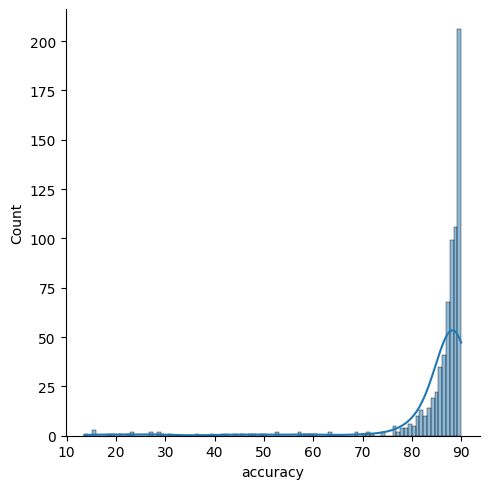

In [ ]:
import seaborn as sns
sns.displot(under_threshold['accuracy'], kde=True)